# TP53 Exploratory Notebook

In [7]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import CPTAC.Endometrial as CPTAC

## Set up initial dataframes and variables

In [8]:
gene='TP53'
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()
transcriptomics = CPTAC.get_transcriptomics()

#A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.P250L', 'p.R248W', 'p.S241C', 'p.S241del', 'p.K164E', 'p.R249S', 'p.R273H', 'p.R282W',
                    'p.S127Y', 'p.G244D', 'p.A159P']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

## Test and plot a single protein (proteomics)

23
CDK1: 8.797191558024237e-05


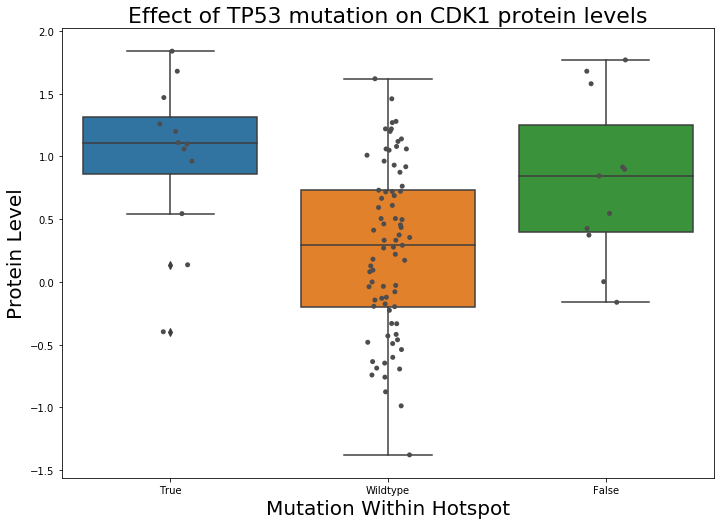

In [96]:
gene = 'TP53'
protein = 'CDK1'

p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
p53_mutations_protein['Within_Hotspot'] = False
p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)
mutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
print(len(mutated))
if len(mutated) > 2:
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        print(protein + ": " + str(ttest[1]))
else:
    print("There are not enough mutations within the hotspot to do a t-test")
    
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, ax = ax)
boxplt = sns.stripplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein + " protein levels", fontsize='22')
plt.show()

## Test and plot a single protein (phosphoproteomics)

Site PLK1-T210: 0.0002117293453374547
PLK1-T214 not significant


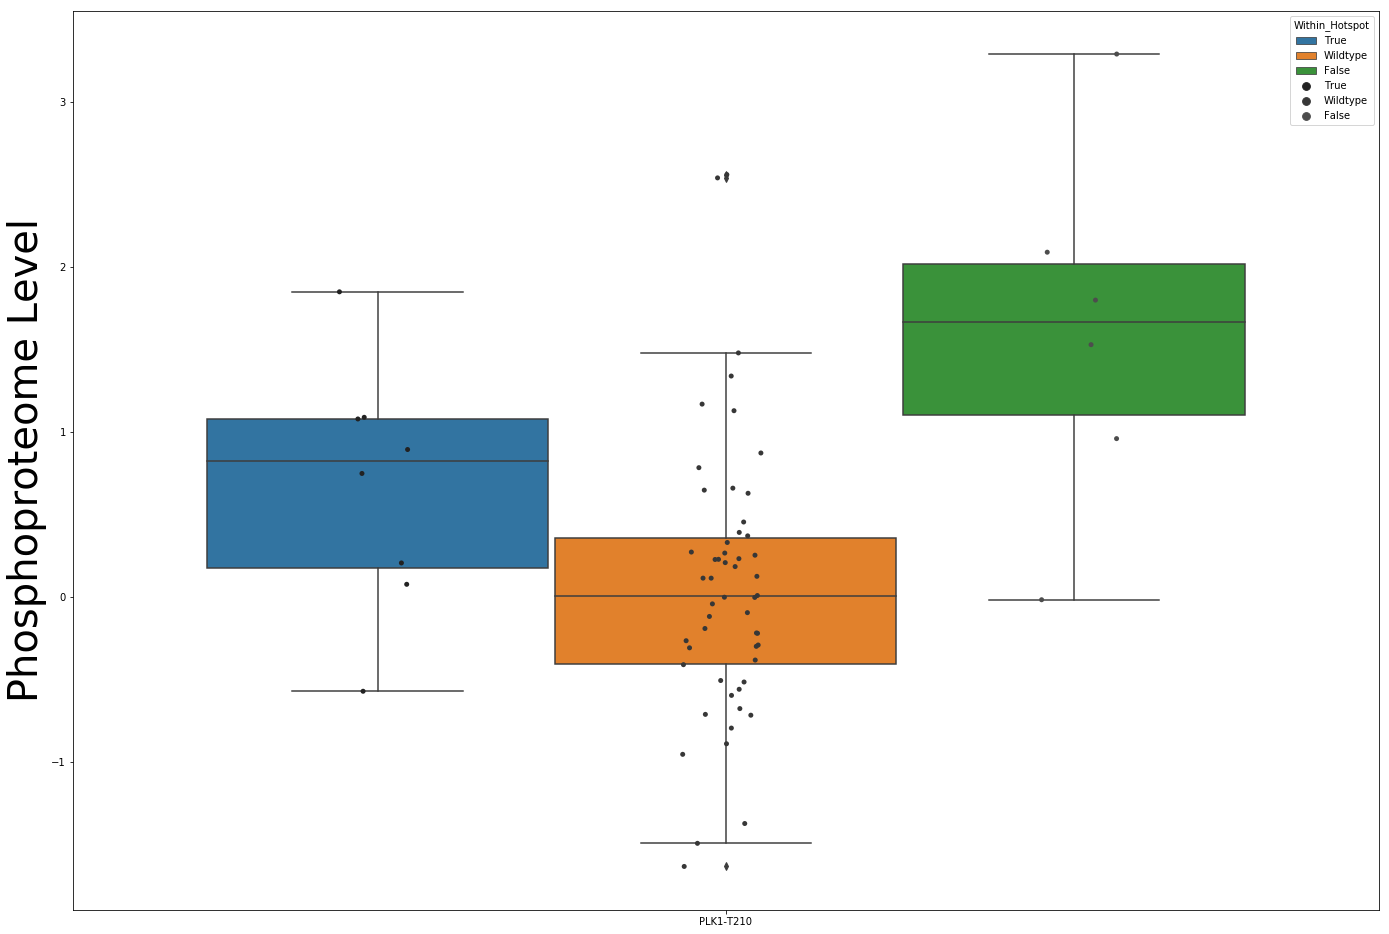

In [97]:
gene = 'TP53'
protein = 'PLK1'

pattern = re.compile(protein)

p53_mutations_protein = CPTAC.compare_mutations(phos, protein, gene)
p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)
p53_mutations_protein['Within_Hotspot'] = False
p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p53_mutations_protein.drop('Mutation', axis=1)

plotdf = p53_mutations_protein[['Within_Hotspot']]

pcutoff = 0.05/len(p53_mutations_protein.columns)

for site in p53_mutations_protein.columns:
    if (site != 'Within_Hotspot' and site != 'Mutation'):
        sitedf = p53_mutations_protein[[site, 'Within_Hotspot']].dropna(axis=0)
        mutated = sitedf.loc[sitedf['Within_Hotspot'] != 'Wildtype']
        wt = sitedf.loc[sitedf['Within_Hotspot'] == 'Wildtype']
        if mutated.empty:
            print("Not enough mutated values for site " + site)
            continue
        if wt.empty:
            print("Not enough wildtype values for site " + site)
            continue
        if len(mutated[site]) < 2:
            print("Not enough mutated values for site " + site)
            continue
        ttest = scipy.stats.ttest_ind(mutated[site], wt[site])
        if ttest[1] < pcutoff:
            print("Site " + site + ": " + str(ttest[1]))
            plotdf = plotdf.join(p53_mutations_protein[site])
        else:
            print(site + " not significant")
            
plotdf = pd.melt(plotdf, id_vars = ['Within_Hotspot'], var_name = 'Site', value_name = 'Phos')
plotdf = plotdf.dropna(axis = 0)
            
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)

#Create the plot
boxplt = sns.boxplot(x='Site', y='Phos', hue='Within_Hotspot', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phos', hue='Within_Hotspot', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Phosphoproteome Level', fontsize='40')
boxplt.tick_params(labelsize='10')


## Transcriptome differences

Ttest_indResult(statistic=4.837930381049433, pvalue=5.880257515950521e-06)


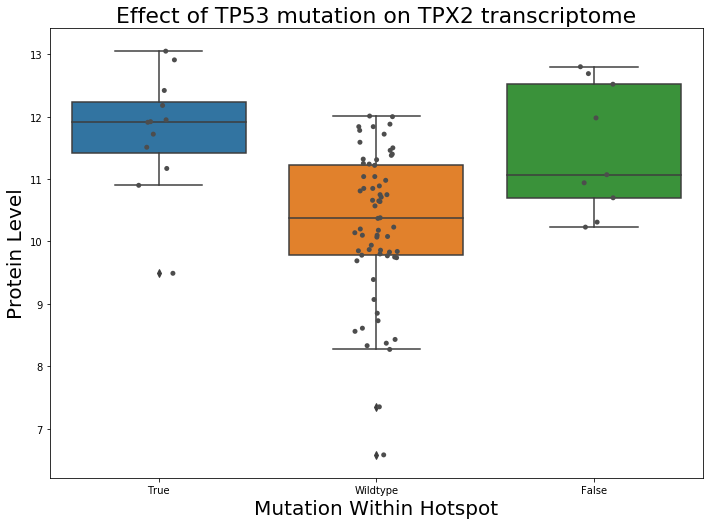

In [87]:
gene = 'TP53'
protein = 'TPX2'

p53_transcript_mut = CPTAC.compare_mutations(proteomics, gene)
p53_transcript_mut['Within_Hotspot'] = False
p53_transcript_mut.loc[hotspot_patients, 'Within_Hotspot'] = True
p53_transcript_mut.loc[p53_transcript_mut['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p53_transcript_mut = p53_transcript_mut.loc[p53_transcript_mut['Patient_Type'] == 'Tumor'].dropna(axis=0)
prot_transcript = transcriptomics[protein]

transcript_analysis = p53_transcript_mut.join(prot_transcript).drop(gene, axis=1).dropna(axis=0)
transcript_analysis = transcript_analysis.loc[transcript_analysis['Patient_Type'] == 'Tumor']

in_hotspot = transcript_analysis.loc[transcript_analysis['Within_Hotspot'] != 'Wildtype']
outside_hotspot = transcript_analysis.loc[transcript_analysis['Within_Hotspot'] == 'Wildtype']
print(scipy.stats.ttest_ind(in_hotspot[protein], outside_hotspot[protein]))

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = transcript_analysis, x = 'Within_Hotspot', y = protein, ax = ax)
boxplt = sns.stripplot(data = transcript_analysis, x = 'Within_Hotspot', y = protein, jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
boxplt.set_title("Effect of " + gene + " mutation on " + protein + " transcriptome", fontsize='22')
plt.show()

## Census of p53 target genes
PMID: 28288132

In [34]:
target_genes = ['ABCA12', 'ABCB1', 'ACAD11', 'ACTA2', 'AEN', 'AFP', 'AGT', 'AGTR1', 'AIFM1', 'AIFM2', 'ALOX5', 'ANLN', 'ANXA1', 'APAF1', 'APC', 'APEX1', 'APOB', 'APOBEC1', 'AR', 'ARID3A', 'ARNT2', 'ATF3', 'ATR', 'BAK1', 'BANP', 'BAX', 'BBC3', 'BCL2', 'BCL2L14', 'BCL6', 'BDKRB2', 'BID', 'BIRC5', 'BNIP3', 'BNIP3L', 'BRCA2', 'BTG2', 'BTG3', 'C10orf54', 'CASP1', 'CASP10', 'CASP6', 'CAV1', 'CBL', 'CCNB1', 'CCNB2', 'CCNG1', 'CCNK', 'CD44', 'CD82', 'CDC20', 'CDC25B', 'CDC25C', 'CDIP1', 'CDK1', 'CDKN1A', 'CDKN2A', 'CEL', 'CERS6', 'CES2', 'CGB7', 'CHEK1', 'CHMP4C', 'CKM', 'CKS2', 'COL18A1', 'COMT', 'CPT1C', 'CRYZ', 'CSF1', 'CST3', 'CST5', 'CTF1', 'CTSD', 'CX3CL1', 'CYFIP2', 'CYP21A2', 'NSG1', 'DAPK1', 'DDB2', 'DDR1', 'DEC1', 'DEF6', 'DGKZ', 'DHRS3', 'DKK1', 'DNMT1', 'DRAM1', 'DSP', 'DUSP1', 'DUSP2', 'DUSP4', 'DUSP5', 'DUSP6', 'DUT', 'E2F7', 'ECT2', 'EDA2R', 'EDN2', 'EGFR', 'EGR2', 'EPCAM', 'EPHA2', 'ERAP1', 'ERCC1', 'ESR1', 'F2R', 'FANCC', 'FAS', 'FBXO22', 'FDFT1', 'FDPS', 'FDXR', 'FLT1', 'FOS', 'FOXF1', 'FOXP3', 'FUCA1', 'FZD2', 'GAD2', 'GADD45A', 'GAMT', 'GBP1', 'GCH1', 'GDF15', 'GDF9', 'GFI1', 'GLS2', 'GPR87', 'GPX1', 'GSTP1', 'HAMP', 'HDC', 'HIC1', 'HMGCLL1', 'HMGCR', 'HNF4A', 'HPSE', 'HRAS', 'HSP90AB1', 'HSPA8', 'HTT', 'ID2', 'IER3', 'IER5', 'IFI16', 'IGF1R', 'IGFBP3', 'IRF2BP2', 'IRF5', 'IRF9', 'ISCU', 'KIAA0513', 'KITLG', 'KLLN', 'KRT14', 'KRT8', 'LARP1', 'LASP1', 'LDLR', 'LGALS3', 'LIF', 'LIMK2', 'LMNA', 'LONP1', 'LPIN1', 'MAD1L1', 'MAP4', 'MAP4K4', 'MAPK8', 'MB', 'MDM2', 'ME1', 'ME2', 'ME3', 'MET', 'MFN2', 'MLH1', 'MMP2', 'MPZL2', 'MSH2', 'MTA1', 'MVK', 'MYC', 'MYOG', 'NANOG', 'NCF2', 'NDRG1', 'NEK2', 'NINJ1', 'NLRC4', 'NOL3', 'NOS3', 'NOTCH1', 'NOV', 'NR0B2', 'ODC1', 'OGN', 'ORM2', 'PADI4', 'PANK1', 'PARK2', 'PAX2', 'PCBP4', 'PCDH10', 'PCNA', 'PEBP1', 'PERP', 'PGF', 'PHF1', 'PHLDA3', 'PIDD1', 'PIK3CA', 'PKD1', 'PLAGL1', 'PLK1', 'PLK2', 'PLK3', 'PLTP', 'PMAIP1', 'PML', 'PMS2', 'POLD1', 'POLH', 'POMC', 'PPARGC1A', 'PPARGC1B', 'PPM1D', 'PPM1J', 'PRAP1', 'PRC1', 'PRDM1', 'PRKAB1', 'PRODH', 'PROM1', 'PSRC1', 'PTCHD4', 'PTEN', 'PTGS2', 'PTK2', 'PTP4A1', 'PTPN6', 'PTPRVP', 'PTTG1', 'PYCARD', 'RAB6C', 'RABGGTA', 'RAD17', 'RAD23A', 'RAD51', 'RAP2B', 'RARA', 'RARRES3', 'RB1', 'RBM38', 'RBPJ', 'RECQL4', 'RFC4', 'RGCC', 'RHOC', 'RND3', 'RNF144B', 'RPS27L', 'RRAD', 'RRM2B', 'RTN4', 'RCHY1', 'S100A2', 'S100A9', 'SALL2', 'SCD', 'SCN3B', 'SEMA3B', 'SEMA3F', 'SERPINA6', 'SERPINB5', 'SERPINE1', 'SESN1', 'SGK1', 'SH2D1A', 'SHBG', 'SIAH1', 'SIVA1', 'SLC2A4', 'SLC38A2', 'SLC6A6', 'SLC7A11', 'SOD2', 'SPATA18', 'STAG1', 'STX6', 'SUB1', 'SULF2', 'SUSD6', 'SYK', 'TBXAS1', 'TDG', 'TFAP2A', 'TFAP2C', 'TFF2', 'TGFA', 'TGM2', 'TIGAR', 'TLR10', 'TLR2', 'TLR3', 'TLR4', 'TLR5', 'TLR6', 'TLR8', 'RP11-330H6.5', 'TNFRSF10A', 'TNFRSF10B', 'TNFSF9', 'TP53AIP1', 'TP53BP1', 'TP53I3', 'TP53INP1', 'TP63', 'TP73', 'TPT1', 'TRAF4', 'TRIAP1', 'TRIM22', 'TRIM32', 'TRPC7', 'TSC2', 'TYRP1', 'UBD', 'UBTD1', 'ULK1', 'ULK2', 'UNC5A', 'UTF1', 'VCAN', 'VDR', 'XPC', 'XPO1', 'YPEL3', 'YWHAG', 'ZFP36', 'ZMAT3', 'ZNF79']

### Proteomic analysis

In [35]:
proteomic_significant = []
proteomic_nochange = []
for protein in target_genes:
    if protein in proteomics.columns:
        p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)
        mutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] != 'Wildtype']
        wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated) > 2:
                ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
                if(ttest[1] < 0.001):
                    proteomic_significant.append(protein)
                else:
                    proteomic_nochange.append(protein)

In [40]:
transcript_significant = []
transcript_nochange = []
for protein in target_genes:
    if protein in transcriptomics.columns:
        p53_transcript_mut = CPTAC.compare_mutations(proteomics, gene)
        p53_transcript_mut['Within_Hotspot'] = False
        p53_transcript_mut.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_transcript_mut.loc[p53_transcript_mut['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_transcript_mut = p53_transcript_mut.loc[p53_transcript_mut['Patient_Type'] == 'Tumor'].dropna(axis=0)
        prot_transcript = transcriptomics[protein]

        transcript_analysis = p53_transcript_mut.join(prot_transcript).drop(gene, axis=1).dropna(axis=0)
        transcript_analysis = transcript_analysis.loc[transcript_analysis['Patient_Type'] == 'Tumor']

        in_hotspot = transcript_analysis.loc[transcript_analysis['Within_Hotspot'] != 'Wildtype']
        outside_hotspot = transcript_analysis.loc[transcript_analysis['Within_Hotspot'] == 'Wildtype']
        if len(in_hotspot) > 2:
            ttest = scipy.stats.ttest_ind(in_hotspot[protein], outside_hotspot[protein])
            if(ttest[1] < 0.001):
                transcript_significant.append(protein)
            else:
                transcript_nochange.append(protein)

In [37]:
proteomic_significant

['ANLN',
 'BIRC5',
 'CCNB1',
 'CCNK',
 'CDC20',
 'CDK1',
 'CDKN2A',
 'DDB2',
 'ECT2',
 'ESR1',
 'FAS',
 'FBXO22',
 'FDXR',
 'FUCA1',
 'HSP90AB1',
 'IRF9',
 'MB',
 'MSH2',
 'PCNA',
 'PLK1',
 'PROM1',
 'RFC4',
 'RPS27L',
 'SALL2',
 'SLC38A2',
 'SPATA18',
 'TRIM32',
 'XPC',
 'XPO1']

In [42]:
transcript_significant

['AEN',
 'APC',
 'BAK1',
 'BBC3',
 'BIRC5',
 'CDC20',
 'CDC25B',
 'CDC25C',
 'CDKN1A',
 'CDKN2A',
 'DDB2',
 'ECT2',
 'ESR1',
 'FAS',
 'FDXR',
 'GBP1',
 'HSP90AB1',
 'ID2',
 'IRF9',
 'MB',
 'MDM2',
 'MPZL2',
 'MSH2',
 'PIK3CA',
 'PLK1',
 'PLTP',
 'POLD1',
 'PRAP1',
 'PRKAB1',
 'PSRC1',
 'RB1',
 'RBM38',
 'RECQL4',
 'RFC4',
 'RPS27L',
 'SESN1',
 'SPATA18',
 'SYK',
 'TLR3',
 'TNFRSF10B',
 'TP53AIP1',
 'TPT1',
 'TRIM32',
 'ULK2',
 'XPC',
 'XPO1',
 'ZMAT3']

## Proteins where both the proteome and the transcriptome are affected

In [46]:
list(set(transcript_significant) & set(proteomic_significant))

['TRIM32',
 'CDC20',
 'DDB2',
 'FAS',
 'BIRC5',
 'ESR1',
 'SPATA18',
 'HSP90AB1',
 'ECT2',
 'RFC4',
 'CDKN2A',
 'MSH2',
 'XPC',
 'FDXR',
 'PLK1',
 'XPO1',
 'IRF9',
 'MB',
 'RPS27L']

## Proteome affected, transcriptome not

In [47]:
list(set(proteomic_significant) - set(transcript_significant))

['CCNB1',
 'FUCA1',
 'SLC38A2',
 'PROM1',
 'FBXO22',
 'CCNK',
 'ANLN',
 'PCNA',
 'SALL2',
 'CDK1']

## Transcriptome affected, proteome not

In [48]:
list(set(transcript_significant) - set(proteomic_significant))

['TLR3',
 'TNFRSF10B',
 'CDKN1A',
 'MPZL2',
 'APC',
 'PLTP',
 'RBM38',
 'MDM2',
 'BAK1',
 'PIK3CA',
 'GBP1',
 'CDC25C',
 'BBC3',
 'PRKAB1',
 'TP53AIP1',
 'RECQL4',
 'ULK2',
 'ZMAT3',
 'PSRC1',
 'AEN',
 'TPT1',
 'POLD1',
 'PRAP1',
 'RB1',
 'CDC25B',
 'SESN1',
 'SYK',
 'ID2']

# Hotspot/transcriptome analysis

In [61]:
hp_proteomic_significant = []
hp_proteomic_nochange = []
for protein in target_genes:
    if protein in proteomics.columns:
        p53_mutations_protein = CPTAC.compare_mutations(proteomics, protein, gene)
        p53_mutations_protein['Within_Hotspot'] = False
        p53_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_mutations_protein.loc[p53_mutations_protein['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_mutations_protein = p53_mutations_protein.loc[p53_mutations_protein['Patient_Type'] == 'Tumor'].dropna(axis=0)
        mutated = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == True]
        wt = p53_mutations_protein.loc[p53_mutations_protein['Within_Hotspot'] == 'Wildtype']
        if len(mutated) > 2:
                ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
                if(ttest[1] < 0.001):
                    hp_proteomic_significant.append(protein)
                else:
                    hp_proteomic_nochange.append(protein)

In [62]:
hp_transcript_significant = []
hp_transcript_nochange = []
for protein in target_genes:
    if protein in transcriptomics.columns:
        p53_transcript_mut = CPTAC.compare_mutations(proteomics, gene)
        p53_transcript_mut['Within_Hotspot'] = False
        p53_transcript_mut.loc[hotspot_patients, 'Within_Hotspot'] = True
        p53_transcript_mut.loc[p53_transcript_mut['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        p53_transcript_mut = p53_transcript_mut.loc[p53_transcript_mut['Patient_Type'] == 'Tumor'].dropna(axis=0)
        prot_transcript = transcriptomics[protein]

        transcript_analysis = p53_transcript_mut.join(prot_transcript).drop(gene, axis=1).dropna(axis=0)
        transcript_analysis = transcript_analysis.loc[transcript_analysis['Patient_Type'] == 'Tumor']

        in_hotspot = transcript_analysis.loc[transcript_analysis['Within_Hotspot'] == True]
        outside_hotspot = transcript_analysis.loc[transcript_analysis['Within_Hotspot'] == 'Wildtype']
        if len(in_hotspot) > 2:
            ttest = scipy.stats.ttest_ind(in_hotspot[protein], outside_hotspot[protein])
            if(ttest[1] < 0.001):
                hp_transcript_significant.append(protein)
            else:
                hp_transcript_nochange.append(protein)

In [63]:
hp_proteomic_significant

['ANLN',
 'CCNB1',
 'CCNK',
 'CDC20',
 'CDK1',
 'CDKN2A',
 'DDB2',
 'ECT2',
 'FAS',
 'FBXO22',
 'FDXR',
 'GBP1',
 'HSP90AB1',
 'IRF9',
 'MSH2',
 'PLK1',
 'RFC4',
 'SLC38A2',
 'SPATA18',
 'TRIM32',
 'XPC',
 'XPO1']

In [64]:
hp_transcript_significant

['AEN',
 'APC',
 'BAK1',
 'CDKN1A',
 'DDB2',
 'ERCC1',
 'ESR1',
 'FDXR',
 'GBP1',
 'GSTP1',
 'HSP90AB1',
 'ID2',
 'IRF9',
 'MDM2',
 'MPZL2',
 'MSH2',
 'PIK3CA',
 'PLK1',
 'RAD23A',
 'RBM38',
 'RECQL4',
 'RFC4',
 'RPS27L',
 'SESN1',
 'SPATA18',
 'TPT1',
 'TRIM32',
 'ULK2',
 'XPC',
 'XPO1']